## Camera calibration



In [2]:
# Load nessesery modules and set up
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error
%matplotlib inline

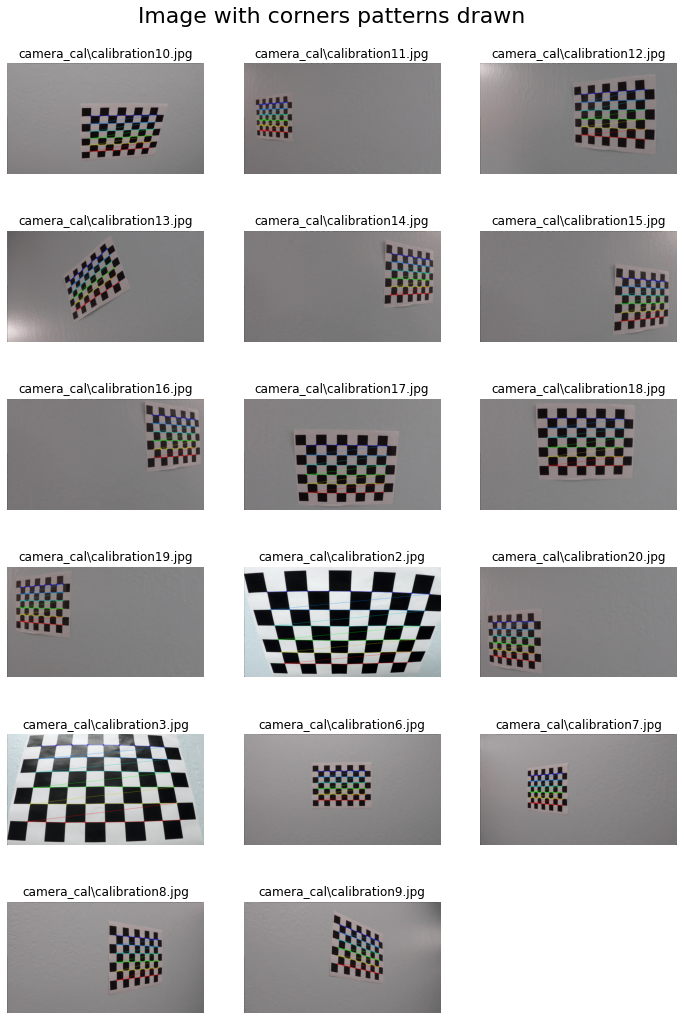

Corners were found on 17 out of 20 it is 85.0 % of calibration images


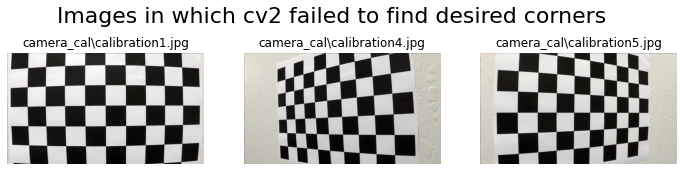

In [3]:
x_cor = 9 #Number of corners to find
y_cor = 6
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((y_cor*x_cor,3), np.float32)
objp[:,:2] = np.mgrid[0:x_cor, 0:y_cor].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('camera_cal/calibration*.jpg') # Make a list of paths to calibration images
# Step through the list and search for chessboard corners
corners_not_found = [] #Calibration images in which opencv failed to find corners
plt.figure(figsize=(12, 18)) #Figure for calibration images
plt.figtext(0.5,0.9,'Image with corners patterns drawn', fontsize=22, ha='center')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Conver to grayscale
    ret, corners = cv2.findChessboardCorners(gray, (x_cor,y_cor), None) # Find the chessboard corners
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        plt.subplot(6, 3, len(imgpoints))
        cv2.drawChessboardCorners(img, (x_cor,y_cor), corners, ret)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')
    else:
        corners_not_found.append(fname)
plt.show()

print ('Corners were found on', str(len(imgpoints)), 'out of', str(len(images)), 'it is',    str(len(imgpoints)*100.0/len(images)),'% of calibration images')
# Draw pictures
plt.figure(figsize=(12, 4))
plt.figtext(.5,.8,'Images in which cv2 failed to find desired corners', fontsize=22, ha='center')
for i, p in enumerate(corners_not_found):
    plt.subplot(1, 3, i+1)
    plt.imshow(mpimg.imread(p)) #draw the first image of each class
    plt.title(p)
    plt.axis('off')
plt.show()
#plt.savefig("readme_img/no_corners.jpg")

As we can see, 85% (17 out of 20) of calibration images were succesfully recognized by `cv2.findChessboardCorners`. The rest 3 images were not processed as the algorithm failed to find required number of corners. 

Text(0.5, 1.0, 'Undistorted Image')

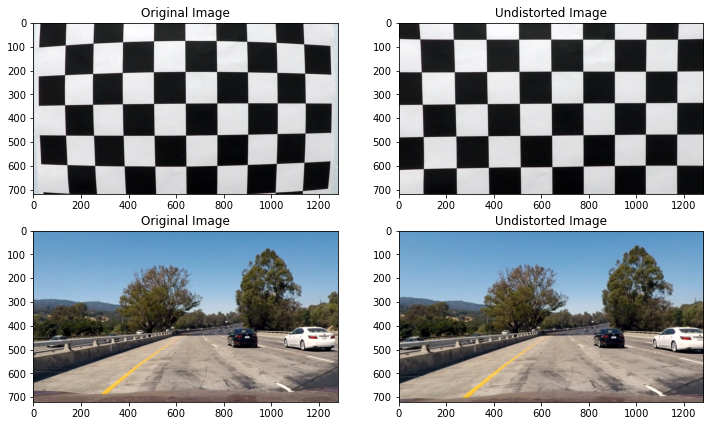

In [5]:
# Undistortion process
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 2, 2)
plt.imshow(undistort(img))
plt.title("Undistorted Image")
img = cv2.imread('test_images/test1.jpg')
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(undistort(img), cv2.COLOR_BGR2RGB))
plt.title("Undistorted Image")
#plt.savefig("readme_img/undist_img.jpg")


## Create of thresholded binary image

The following functions were implemented to perform Histogram normalization, binary Sobel transformation (including magnitude and direction), red color channel and saturation channel. 

Unfortunately, the optimal combination of these filters which is able to separate pixels of lane line from background on snapshots from all three videos was not found. Shadows and glares are quite challenging. (For first two videos such filter combination was successfully found).

So, an adaptive threshold was applied (see description below) on a red channel image for white line finding and on a linear combination of the red and saturation channels - for the yellow line. An example is presented after the code chunk. 

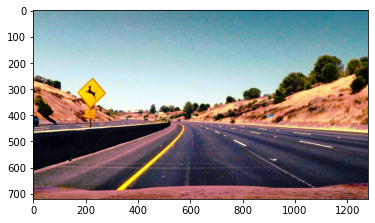

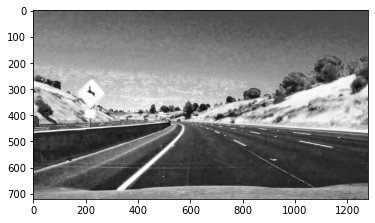

In [6]:
def eq_Hist(img): # Histogram normalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img

# Sobel
def sobel_img(img, thresh_min = 25, thresh_max = 255, sobel_kernel = 11):
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobelx = np.uint16(255*sobelx/np.max(sobelx))
    scaled_sobely = np.uint16(255*sobely/np.max(sobely))
    sobel_sum = scaled_sobelx+0.2*scaled_sobely
    scaled_sobel_sum = np.uint8(255*sobel_sum/np.max(sobel_sum))
    sum_binary = np.zeros_like(scaled_sobel_sum)
    sum_binary[(scaled_sobel_sum >= thresh_min) & (scaled_sobel_sum <= thresh_max)] = 1
    return sum_binary

# Solbel magnitude
def sobel_mag_img(img, thresh_min = 25, thresh_max = 255, sobel_kernel = 11):
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_gradmag = np.uint8(255*gradmag/np.max(gradmag))
    gradmag_binary = np.zeros_like(scaled_gradmag)
    gradmag_binary[(scaled_gradmag >= thresh_min) & (scaled_gradmag <= thresh_max)] = 1
    return gradmag_binary

# Sobel direction
def sobel_dir_img(img, thresh_min = 0.0, thresh_max = 1.5, sobel_kernel = 11):
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    graddir = np.arctan2(sobely, sobelx)
    graddir_binary =  np.zeros_like(graddir)
    graddir_binary[(graddir >= thresh_min) & (graddir <= thresh_max)] = 1
    return  graddir_binary

# Binary red channel threshold
def red_thres(img, thresh_min = 25, thresh_max = 255):
    red = img[:,:,2]
    red_binary = np.zeros_like(red)
    red_binary[(red >= thresh_min) & (red <= thresh_max)]  = 1
    return red_binary

# Binary saturation channel threshold
def s_thres(img, thresh_min = 25, thresh_max = 255):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > thresh_min) & (s_channel <= thresh_max)] = 1
    return s_binary

# Return saturation channel
def s_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    return hls[:,:,2]
# Visualize an example
img = cv2.imread('test_images/test2.jpg')
img = eq_Hist(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img_proc = img[:,:,2]+0.5*s_hls(img)
img_proc = np.uint8(255*img_proc/np.max(img_proc))
plt.figure()
plt.imshow(img_proc, cmap='gray')

Despite we are not using binary image, here is an example, how a binary image, prodused out of the above image, could look like.

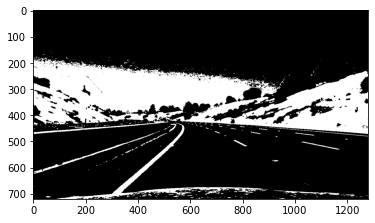

In [8]:
THRES = 250

img = cv2.imread('test_images/test2.jpg')
img = undistort(img)
img = eq_Hist(img)
img_proc = img[:,:,2]+0.5*s_hls(img)
img_proc = img_proc>THRES
img_proc = np.uint8(255*img_proc/np.max(img_proc))
plt.imshow(img_proc, cmap='gray')
#plt.savefig("readme_img/bin_img.jpg")

## Transform image

The section consists of several image transformation functions. There are well known implementation of image sharpening and contrast increase functions as well as image transformation routine.

Points for image warping were selected so parallel lines becomes really parallel. It creates so-called Bird's Eye View. We also crop images to skip areas with hood and sky. An example is provided below.

There are also some simple image viewing functions for quick and easy results visualisation which is very useful during debugging. 

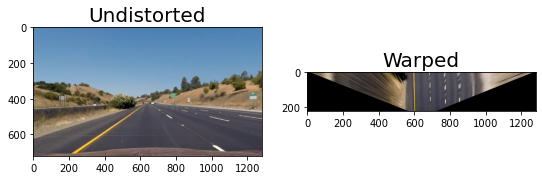

In [10]:
IMAGE_H = 223
IMAGE_W = 1280

# Sharpen image
def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)

# Compute linear image transformation img*s+m
def lin_img(img,s=1.0,m=0.0):
    img2=cv2.multiply(img, np.array([s]))
    return cv2.add(img2, np.array([m]))

# Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
    m=127.0*(1.0-s)
    return lin_img(img, s, m)

# Create perspective image transformation matrices
def create_M():
    src = np.float32([[0, 673], [1207, 673], [0, 450], [1280, 450]])
    dst = np.float32([[569, 223], [711, 223], [0, 0], [1280, 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

# Main image transformation routine to get a warped image
def transform(img, M):
    undist = undistort(img)
    img_size = (IMAGE_W, IMAGE_H)
    warped = cv2.warpPerspective(undist, M, img_size)
    warped = sharpen_img(warped)
    warped = contr_img(warped, 1.1)
    return warped

# Show original and warped image side by side
def show_warped(img, M):
    f, (plot1, plot2) = plt.subplots(1, 2, figsize=(9, 3))
    plot1.imshow(cv2.cvtColor(undistort(img), cv2.COLOR_BGR2RGB))
    plot1.set_title('Undistorted', fontsize=20)
    plot2.imshow(cv2.cvtColor(transform(img, M), cv2.COLOR_BGR2RGB))
    plot2.set_title('Warped', fontsize=20)

# Show one image
def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')

M, Minv = create_M()
for image in glob.glob('test_images/straight_lines1.jpg'): # Example of warped image
    img=cv2.imread(image)
    show_warped(img, M)
    #plt.savefig("readme_img/warped_img3.jpg")

## Math help functions
### Polinomial functions

Here we define some useful math functions (such as first and second derivatives calculation, convert size in pixels into meters, measure lanes curvature), which will be used in the following code.

**Note:** *x = f(y)* coordinate system is used, where *y* is in range [0..1] (vertical axis) and *x* is in range [0..1279] (horizontal axis). It was used to reduse computational error by shifting polynomial coefficients to a reasonably bigger values.

Radius of lanes curvature was calculated out of polinomial lane lines approximation by a formula from a [website](http://www.intmath.com/applications-differentiation/8-radius-curvature.php), which was recomended in the course notes. If the calculated radius is bigger than `MAX_RADIUS` then the `MAX_RADIUS` value is returned because such a big radiuses of curvature are very unaccurate and can be considered as a straight line. Offset from the lane center was estimated as lane ofset in pixels, converted to meters.

In [11]:
#Calculate coefficients of a polynomial in y+h coordinates, i.e. f(y) -> f(y+h)
def pol_shift(pol, h):
    pol_ord = len(pol)-1 # Determinate degree of the polynomial 
    if pol_ord == 3:
        pol0 = pol[0]
        pol1 = pol[1] + 3.0*pol[0]*h
        pol2 = pol[2] + 3.0*pol[0]*h*h + 2.0*pol[1]*h
        pol3 = pol[3] + pol[0]*h*h*h + pol[1]*h*h + pol[2]*h
        return(np.array([pol0, pol1, pol2, pol3]))
    if pol_ord == 2:
        pol0 = pol[0]
        pol1 = pol[1] + 2.0*pol[0]*h
        pol2 = pol[2] + pol[0]*h*h+pol[1]*h
        return(np.array([pol0, pol1, pol2]))
    if pol_ord == 1:
        pol0 = pol[0]
        pol1 = pol[1] + pol[0]*h
        return(np.array([pol0, pol1]))


# Calculate derivative for a polynomial pol in a point x
def pol_d(pol, x):
    pol_ord = len(pol)-1
    if pol_ord == 3:
        return 3.0*pol[0]*x*x+2.0*pol[1]*x+pol[2]
    if pol_ord == 2:
        return 2.0*pol[0]*x+pol[1]
    if pol_ord == 1:
        return pol[0]#*np.ones(len(np.array(x)))
    
# Calculate the second derivative for a polynomial pol in a point x
def pol_dd(pol, x):
    pol_ord = len(pol)-1
    if pol_ord == 3:
        return 6.0*pol[0]*x+2.0*pol[1]
    if pol_ord == 2:
        return 2.0*pol[0]
    if pol_ord == 1:
        return 0.0
    
# Calculate a polinomial value in a given point x
def pol_calc(pol, x):
    pol_f = np.poly1d(pol)
    return(pol_f(x))

xm_in_px = 3.675 / 85 # Lane width (12 ft in m) is ~85 px on image
ym_in_px = 3.048 / 24 # Dashed line length (10 ft in m) is ~24 px on image

def px_to_m(px): # Conver ofset in pixels in x axis into m
    return xm_in_px*px

# Calculate offset from the lane center
def lane_offset(left, right):
    offset = IMAGE_W/2.0-(pol_calc(left, 1.0)+ pol_calc(right, 1.0))/2.0
    return px_to_m(offset)

# Calculate radius of curvature of a line
MAX_RADIUS = 10000
def r_curv(pol, y):
    if len(pol) == 2: # If the polinomial is a linear function
        return MAX_RADIUS
    else:
        y_pol = np.linspace(0, 1, num=EQUID_POINTS)
        x_pol = pol_calc(pol, y_pol)*xm_in_px
        y_pol = y_pol*IMAGE_H*ym_in_px
        pol = np.polyfit(y_pol, x_pol, len(pol)-1)
        d_y = pol_d(pol, y)
        dd_y = pol_dd(pol, y)
        r = ((np.sqrt(1+d_y**2))**3)/abs(dd_y)
        if r > MAX_RADIUS:
            r = MAX_RADIUS
        return r
# Calculate radius of curvature of a lane by avaraging lines curvatures
def lane_curv(left, right):
    l = r_curv(left, 1.0)
    r = r_curv(right, 1.0)
    if l < MAX_RADIUS and r < MAX_RADIUS:
        return (r_curv(left, 1.0)+r_curv(right, 1.0))/2.0
    else:
        if l < MAX_RADIUS:
            return l
        if r < MAX_RADIUS:
            return r
        return MAX_RADIUS

### Equidistant for a polynomial

An equidistant is needed in case only one line is well determined (the other one is the equidistant because lane lines are parallel). It is known that an equidistant for a polynomial function is a higher order polynomial function. However, it is needed not higher then 3rd order polynomial in order to make line fitting robust and stable.  That is why we use an approximation: we create a list of equidistant points for the given polinomial (points laying on a straight lines, perpendicular to the given polynomial at selected points on a desired distance) and fit them with a same order polinomial function.The `np.polyfit` function is used for fitting. An example is given below.

[ 79.48823117 -37.45752836 627.44035983]


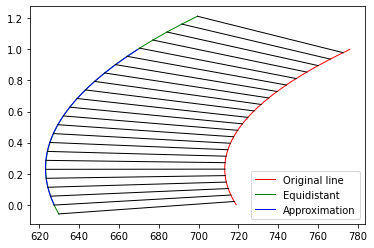

In [13]:
#Calculate approximated equidistant to a parabola
EQUID_POINTS = 25 # Number of points to use for the equidistant approximation
def equidistant(pol, d, max_l = 1, plot = False):
    y_pol = np.linspace(0, max_l, num=EQUID_POINTS)
    x_pol = pol_calc(pol, y_pol)
    y_pol *= IMAGE_H # Convert y coordinates to [0..223] scale
    x_m = []
    y_m = []
    k_m = []
    for i in range(len(x_pol)-1):
        x_m.append((x_pol[i+1]-x_pol[i])/2.0+x_pol[i]) # Calculate polints position between given points
        y_m.append((y_pol[i+1]-y_pol[i])/2.0+y_pol[i])
        if x_pol[i+1] == x_pol[i]:
            k_m.append(1e8) # A vary big number
        else:
            k_m.append(-(y_pol[i+1]-y_pol[i])/(x_pol[i+1]-x_pol[i])) # Slope of perpendicular lines
    x_m = np.array(x_m)
    y_m = np.array(y_m)
    k_m = np.array(k_m)
    #Calculate equidistant points
    y_eq = d*np.sqrt(1.0/(1+k_m**2))
    x_eq = np.zeros_like(y_eq)
    if d >= 0:
        for i in range(len(x_m)):
            if k_m[i] < 0:
                y_eq[i] = y_m[i]-abs(y_eq[i])
            else:
                y_eq[i] = y_m[i]+abs(y_eq[i])
            x_eq[i] = (x_m[i]-k_m[i]*y_m[i])+k_m[i]*y_eq[i]
    else:
        for i in range(len(x_m)):
            if k_m[i] < 0:
                y_eq[i] = y_m[i]+abs(y_eq[i])
            else:
                y_eq[i] = y_m[i]-abs(y_eq[i])
            x_eq[i] = (x_m[i]-k_m[i]*y_m[i])+k_m[i]*y_eq[i]
    y_eq /= IMAGE_H # Convert all y coordinates back to [0..1] scale
    y_pol /= IMAGE_H
    y_m /= IMAGE_H
    pol_eq = np.polyfit(y_eq, x_eq, len(pol)-1) # Fit equidistant with a polinomial
    if plot: #Visualize results
        plt.plot(x_pol, y_pol, color='red', linewidth=1, label = 'Original line') #Original line
        plt.plot(x_eq, y_eq, color='green', linewidth=1, label = 'Equidistant') #Equidistant
        plt.plot(pol_calc(pol_eq, y_pol), y_pol, color='blue',
                 linewidth=1, label = 'Approximation') #Approximation
        plt.legend()
        for i in range(len(x_m)):
            plt.plot([x_m[i],x_eq[i]], [y_m[i],y_eq[i]], color='black', linewidth=1) #Draw connection lines
        #plt.savefig('readme_img/equid.jpg')
    return pol_eq

pol = np.array([106.65796008,  -49.57665396,  718.87055435])
print(equidistant(pol, -90, plot=True))

### Choose the best polynomial order

One of the key ideas of the project is the usage of the reasonable minimal order of polinomial functions for lines fitting. The function `best_pol_ord` chooses such order. It starts from a linear function and, if it does not perform well enough increases the polinomial order (up to 3). It returns polinomial coefficients and mean squared error of the selected approximation.
The function stops increasing the order if it does not help (mean squared error drops not significant in case of higher order) or in case the mean squared error is small enough (`< DEV_POL`).

It is possible to use a simple low pass filter or an alpha-beta filter for smoothing polynomial coefficients of the same degree. But for two polynomial with different orders a dedicated function `smooth_dif_ord` was introduced. It calculates average x position of points for a given function f(y)  at y values from the new dataset and fit these new average points with polinomial of desired degree.

In [14]:
# Choose the best polynomial order to fit points (x,y)
DEV_POL = 2 # Max mean squared error of the approximation
MSE_DEV = 1.1 # Minimum mean squared error ratio to consider higher order of the polynomial
def best_pol_ord(x, y):
    pol1 = np.polyfit(y,x,1)
    pred1 = pol_calc(pol1, y)
    mse1 = mean_squared_error(x, pred1)
    if mse1 < DEV_POL:
        return pol1, mse1
    pol2 = np.polyfit(y,x,2)
    pred2 = pol_calc(pol2, y)
    mse2 = mean_squared_error(x, pred2)
    if mse2 < DEV_POL or mse1/mse2 < MSE_DEV:
            return pol2, mse2
    else:
        pol3 = np.polyfit(y,x,3)
        pred3 = pol_calc(pol3, y)
        mse3 = mean_squared_error(x, pred3)
        if mse2/mse3 < MSE_DEV:
            return pol2, mse2
        else:
            return pol3, mse3
    
# Smooth polinomial functions of different degrees   
def smooth_dif_ord(pol_p, x, y, new_ord):
    x_p = pol_calc(pol_p, y)
    x_new = (x+x_p)/2.0
    return np.polyfit(y, x_new, new_ord)

## Lane detection and drawing

### Thresholds

For yellow line detection combination of the red and saturation channels is used while for white line red channel only is used. That is why, there are two different functions, obtained empirically, for threshold calculation presented below.

In [15]:
# Calculate threashold for left line
def thres_l_calc(sens):
    thres = -0.0045*sens**2+1.7581*sens-115.0
    if thres < 25*(382.0-sens)/382.0+5:
        thres = 25*(382.0-sens)/382.0+5
    return thres

# Calculate threashold for right line
def thres_r_calc(sens):
    thres = -0.0411*sens**2+9.1708*sens-430.0
    if sens<210:
        if thres < sens/6:
            thres = sens/6
    else:
        if thres < 20:
            thres = 20
    return thres

### The virtual sensors

The main magic happens here.

The *`find`* function finds points from line on an image. It has an optional argument *pol* which can be used to specify region of search by a polinomial function *x = f(y)* and *max_n* - maximum *y* value to use with the function. The virtual sensors concept descussed in detail in the *README.md* file.

In [16]:
# Create virtual sensors
WINDOW_SIZE = 15 # Half of the sensor span
DEV = 7 # Maximum of the point deviation from the sensor center
SPEED = 2 / IMAGE_H # Pixels shift per frame
POL_ORD = 2 # Default polinomial order
RANGE = 0.0 # Fraction of the image to skip

def find(img, left=True, p_ord=POL_ORD, pol = np.zeros(POL_ORD+1), max_n = 0):
    x_pos = [] #lists of found points
    y_pos = []
    max_l = img.shape[0] #number of lines in the img
    for i in range(max_l-int(max_l*RANGE)):
        y = max_l-i #Line number
        y_01 = y / float(max_l) #y in [0..1] scale
        if abs(pol[-1]) > 0: #If it not a still image or the first video frame
            if y_01 >= max_n + SPEED: # If we can use pol to find center of the virtual sensor from the previous frame 
                cent = int(pol_calc(pol, y_01-SPEED))
                if y == max_l:
                    if left:
                        cent = 605
                    else:
                        cent = 690
            else: # Prolong the pol tangentially
                k = pol_d(pol, max_n)
                b = pol_calc(pol, max_n)-k*max_n
                cent = int(k*y_01+b)
            if cent > IMAGE_W-WINDOW_SIZE:
                cent = IMAGE_W-WINDOW_SIZE
            if cent < WINDOW_SIZE:
                cent = WINDOW_SIZE
        else: #If it is a still image
            if len(x_pos) > 0: # If there are some points detected
                cent = x_pos[-1] # Use the previous point as a senser center
            else: #Initial guess on line position
                if left:
                    cent = 605
                else:
                    cent = 690
        if left: #Subsample image
            sens = 0.5*s_hls(img[max_l-1-i:max_l-i,cent-WINDOW_SIZE:cent+WINDOW_SIZE,:])\
            +img[max_l-1-i:max_l-i,cent-WINDOW_SIZE:cent+WINDOW_SIZE,2]
        else:
            sens = img[max_l-1-i:max_l-i,cent-WINDOW_SIZE:cent+WINDOW_SIZE,2] # Red channel only for right white line
        if len(sens[0,:]) < WINDOW_SIZE: #If we out of the image
                break
        x_max = max(sens[0,:]) #Find maximal value on the sensor
        sens_mean = np.mean(sens[0,:])
        # Get threshold
        if left:
            loc_thres = thres_l_calc(sens_mean)
            loc_dev = DEV
        else:
            loc_thres = thres_r_calc(sens_mean)
            loc_dev = DEV
        if len(x_pos) == 0:
            loc_dev = WINDOW_SIZE
        if (x_max-sens_mean) > loc_thres and (x_max>100 or left):
            if left:
                x = list(reversed(sens[0,:])).index(x_max)
                x = cent+WINDOW_SIZE-x
            else:
                x = list(sens[0,:]).index(x_max)
                x = cent-WINDOW_SIZE+x
            if x-1 < 569.0*y_01 or x+1 > 569.0*y_01+711 : #if the sensor touchs black triangle
                break # We are done
            if abs(pol[-1]) < 1e-4:  # If there are no polynomial provided     
                x_pos.append(x)
                y_pos.append(y_01)
            else:
                if abs(x-cent) < loc_dev: # If the found point deviated from expected position not significantly
                    x_pos.append(x)
                    y_pos.append(y_01)
    if len(x_pos) > 1:
        return x_pos, y_pos
    else:
        return [0], [0.0]

In [17]:
def find_img(img, left=True, p_ord=POL_ORD, pol = np.zeros(POL_ORD+1), max_n = 0):
    x_pos = [] #lists of found points
    y_pos = []
    max_l = img.shape[0] #number of lines in the img
    b_img = np.zeros_like(img)
    b_img = b_img[:,:,2]
    for i in range(max_l-int(max_l*RANGE)):
        y = max_l-i #Line number
        y_01 = y / float(max_l) #y in [0..1] scale
        if len(x_pos) > 0: # If there are some points detected
            cent = x_pos[-1] # Use the previous point as a senser center
        else: #Initial guess on line position
            if left:
                cent = 605
            else:
                cent = 690
        if left: #Subsample image
            sens = 0.5*s_hls(img[max_l-1-i:max_l-i,cent-WINDOW_SIZE:cent+WINDOW_SIZE,:])\
            +img[max_l-1-i:max_l-i,cent-WINDOW_SIZE:cent+WINDOW_SIZE,2]
        else:
            sens = img[max_l-1-i:max_l-i,cent-WINDOW_SIZE:cent+WINDOW_SIZE,2] # Red channel only for right white line
        if len(sens[0,:]) < WINDOW_SIZE: #If we out of the image
                break
        x_max = max(sens[0,:]) #Find maximal value on the sensor
        sens_mean = np.mean(sens[0,:])
        # Get threshold
        if left:
            loc_thres = thres_l_calc(sens_mean)
            loc_dev = DEV
        else:
            loc_thres = thres_r_calc(sens_mean)
            loc_dev = DEV
        #print((sens-sens_mean)>loc_thres)
        b_img[max_l-1-i:max_l-i,cent-WINDOW_SIZE:cent+WINDOW_SIZE]=(sens-sens_mean)>loc_thres
        if len(x_pos) == 0:
            loc_dev = WINDOW_SIZE
        if (x_max-sens_mean) > loc_thres and (x_max>100 or left):
            if left:
                x = list(reversed(sens[0,:])).index(x_max)
                x = cent+WINDOW_SIZE-x
            else:
                x = list(sens[0,:]).index(x_max)
                x = cent-WINDOW_SIZE+x
            if x-1 < 569.0*y_01 or x+1 > 569.0*y_01+711 : #if the sensor touchs black triangle
                break # We are done
            if abs(pol[-1]) < 1e-4:  # If there are no polynomial provided     
                x_pos.append(x)
                y_pos.append(y_01)
            else:
                if abs(x-cent) < loc_dev: # If the found point deviated from expected position not significantly
                    x_pos.append(x)
                    y_pos.append(y_01)
    
    img_proc=np.uint8(255*b_img/np.max(b_img))
    #show_img(img_proc)
    if len(x_pos) > 1:
        return x_pos, y_pos, img_proc
    else:
        return [0], [0.0]

### Draw line on an image

The following code *`draw_lane`* can draw found lines on images and perform inverse perspective transformation with *Minv* matrix. It is realized in the same way as it was shown in the course lectures. It also inprints radius of curvature of the road and an  offset from the lane center. 

*`get_lane`* function just calls find function to detect lane on an image and visualize results

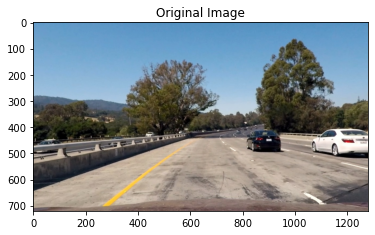

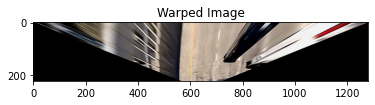

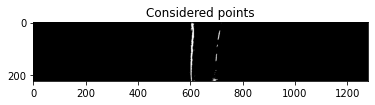

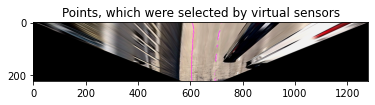

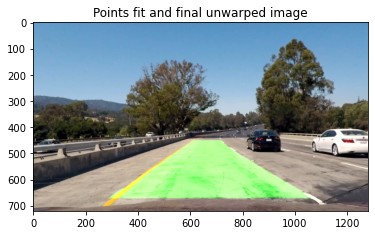

In [21]:
# Get lines on a still image
RANGE = 0.0
def get_lane(img, plot=False):
    warp = transform(img, M)
    img = undistort(img)
    show_img(img)
    plt.title("Original Image")
    #plt.savefig("readme_img/pipeline1.jpg")
    show_img(warp)
    plt.title("Warped Image")
    #plt.savefig("readme_img/pipeline2.jpg")
    ploty = np.linspace(0, 1, num=warp.shape[0])
    x2, y2, im1 = find_img(warp)
    x, y, im2 = find_img(warp, False)
    show_img(im1+im2)
    plt.title("Considered points")
    #plt.savefig("readme_img/pipeline3.jpg")
    right_fitx = pol_calc(best_pol_ord(x,y)[0], ploty)
    left_fitx = pol_calc(best_pol_ord(x2,y2)[0], ploty)
    y2 = np.int16(np.array(y2)*223.0) # Convert into [0..223] scale
    y = np.int16(np.array(y)*223.0)
    if plot: # Results visualisation
        for i in range(len(x)): # Plot points
            cv2.circle(warp, (x[i], y[i]), 1, (255,50,255))
        for i in range(len(x2)):
            cv2.circle(warp, (x2[i], y2[i]), 1, (255,50,250))   
        show_img(warp) 
        #plt.axis('off')
        
        plt.title("Points, which were selected by virtual sensors")
        #plt.savefig("readme_img/pipeline4.jpg")
        #plt.plot(left_fitx, ploty*IMAGE_H, color='green', linewidth=1)
        #plt.plot(right_fitx, ploty*IMAGE_H, color='green', linewidth=1)
        #cv2.imwrite('img.jpg', warp)
    return img,  left_fitx, right_fitx, ploty*IMAGE_H
            
def draw_lane_img_p(img_path): # Image read function
    return cv2.imread(img_path)

def draw_lane(img, video=False): #Draw found lane line onto a normal image
    if video:
        img, left_fitx, right_fitx, ploty, left, right = get_lane_video(img)
    else:
        img, left_fitx, right_fitx, ploty = get_lane(img, True)
    warp_zero = np.zeros((IMAGE_H,IMAGE_W)).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1.0, newwarp, 0.6, 0)
    if video:
        # Add text information on the video frame
        font = cv2.FONT_HERSHEY_SIMPLEX
        text_pos = 'Pos of the car: '+str(np.round(lane_offset(left, right),2))+ ' m'
        radius = np.round(lane_curv(left, right),2)
        if radius >= MAX_RADIUS:
            radius = 'Inf'
        else:
            radius = str(radius)
        text_rad = 'Radius: '+radius+ ' m'
        cv2.putText(result,text_pos,(10,25), font, 1,(255,255,255),2)
        cv2.putText(result,text_rad,(10,75), font, 1,(255,255,255),2)
        return(result)
    else:
        show_img(result)
        plt.title("Points fit and final unwarped image")
        #plt.savefig("readme_img/pipeline5.jpg")

#Test on images from the 'test_images' directory
for image in glob.glob('test_images/test1.jpg'):
    draw_lane(draw_lane_img_p(image))

### Find lane on video

In case of video the same approach as for still images is used. However, line detection process involves several filterings.

The previous polynomial is used to specify region of search for the *`find`* algorithm. Line considered as detected only if there are more than *MIN_POINTS* found. If it fails to find the line for more than *MAX_N* frames it starts search from scratch (initially, on the first frame or in case of line lost it deals with the frame as with a still image). It also skips strange results with very narrow or wide lanes.

In case a line is successfully detected, its coefficients are filtred to smooth jitter. If only one line (only left or only right) is detected, then it uses the *`equidistant`* function to draw the necessary line.

In [22]:
right_fit_p = np.zeros(POL_ORD+1)
left_fit_p = np.zeros(POL_ORD+1)
r_len = 0
l_len = 0
lane_w_p = 90

MIN = 60 # Minimal line separation (in px)
MAX = 95 # Maximal line separation (in px)
MIN_POINTS = 10  #Minimal points to consider a line
MAX_N = 5 # Maximal frames without line detected to use previous frame
n_count = 0 # Frame counter
r_n = 0 # Number of frames with unsuccessful line detection
l_n = 0

def get_lane_video(img):
    global right_fit_p, left_fit_p, r_len, l_len, n_count, r_n, l_n
    sw = False
    warp = transform(img, M)
    img = undistort(img)
    if l_n < MAX_N and n_count > 0:
        x, y = find(warp, pol = left_fit_p, max_n = l_len)
    else:
        x, y = find(warp)
    if len(x) > MIN_POINTS:
        left_fit, mse_l = best_pol_ord(x,y)
        if mse_l > DEV_POL*9 and n_count > 0:
            left_fit = left_fit_p
            l_n += 1
        else:
            l_n /= 2
    else:
        left_fit = left_fit_p
        l_n += 1
    if r_n < MAX_N and n_count > 0:
        x2, y2 = find(warp, False, pol = right_fit_p, max_n = r_len)
    else:
        x2, y2 = find(warp, False)
    if len(x2) > MIN_POINTS:
        right_fit, mse_r = best_pol_ord(x2, y2)
        if mse_r > DEV_POL*9 and n_count > 0:
            right_fit = right_fit_p
            r_n += 1
        else:
            r_n /= 2
    else:
        right_fit = right_fit_p
        r_n += 1
    if n_count > 0: # if not the first video frame
        # Apply filter
        if len(left_fit_p) == len(left_fit): # If new and prev polinomial have the same order
            left_fit = pol_shift(left_fit_p, -SPEED)*(1.0-len(x)/((1.0-RANGE)*IMAGE_H))+left_fit*(len(x)/((1.0-RANGE)*IMAGE_H))
        else:
            left_fit = smooth_dif_ord(left_fit_p, x, y, len(left_fit)-1)
        l_len = y[-1]
        if len(right_fit_p) == len(right_fit):
            right_fit = pol_shift(right_fit_p, -SPEED)*(1.0-len(x2)/((1.0-RANGE)*IMAGE_H))+right_fit*(len(x2)/((1.0-RANGE)*IMAGE_H))
        else:
            right_fit = smooth_dif_ord(right_fit_p, x2, y2, len(right_fit)-1)
        r_len = y2[-1]
        
    if len(x) > MIN_POINTS and len(x2) <= MIN_POINTS: # If we have only left line
        lane_w = pol_calc(right_fit_p, 1.0)-pol_calc(left_fit_p, 1.0)
        right_fit = smooth_dif_ord(right_fit_p, pol_calc(equidistant(left_fit, lane_w, max_l=l_len), y),
                                   y, len(left_fit)-1)
        r_len = l_len
        r_n /=2
    if len(x2) > MIN_POINTS and len(x) <= MIN_POINTS: # If we have only right line
        lane_w = pol_calc(right_fit_p, 1.0)-pol_calc(left_fit_p, 1.0)
        #print(lane_w)
        left_fit = smooth_dif_ord(left_fit_p, pol_calc(equidistant(right_fit, -lane_w, max_l=r_len), y2),
                                  y2, len(right_fit)-1)
        l_len = r_len
        l_n /=2 
    if (l_n < MAX_N and r_n < MAX_N):
        max_y = max(RANGE, l_len, r_len)
    else:
        max_y = 1.0#max(RANGE, l_len, r_len)
        sw = True
    d1 = pol_calc(right_fit, 1.0)-pol_calc(left_fit, 1.0)
    dm = pol_calc(right_fit, max_y)-pol_calc(left_fit, max_y)
    if (d1 > MAX or d1 < 60 or dm < 0):
        left_fit = left_fit_p
        right_fit = right_fit_p
        l_n += 1
        r_n += 1
    ploty = np.linspace(max_y, 1, num=IMAGE_H) 
    left_fitx = pol_calc(left_fit, ploty)
    right_fitx = pol_calc(right_fit, ploty)
    right_fit_p = np.copy(right_fit)
    left_fit_p = np.copy(left_fit)
    n_count += 1
    return img,  left_fitx, right_fitx, ploty*223.0, left_fit, right_fit

## Video processing

Here we process all three task videos of the project.

Video processing approach with `moviepy` from the [first project](https://github.com/NikolasEnt/LaneLine-project) of the Self-Driving Car Nanodegreee.

It was found that the algorithm performs better if it analyzes not so distant points in case of the *harder_challenge_video.mp4* video, that is why we initialize parameters with *RANGE = 0.85* in the case and RANGE = 0.0 (i.e. analize whole warped image) in other cases.

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

# Function to initialize parameters before each video processing
def init_params(ran):
    global right_fit_p, left_fit_p, n_count, RANGE, MIN_POINTS
    right_fit_p = np.zeros(POL_ORD+1)
    left_fit_p = np.zeros(POL_ORD+1)
    n_count = 0
    RANGE = ran
    MIN_POINTS = 25-15*ran
    
def process_image(image):
    return draw_lane(image, True)

# Process videos
init_params(0.0)
output_v = 'video_proc/project_video_proc1.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output_v, audio=False)

init_params(0.0)
output_v = 'video_proc/challenge_video_proc1.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output_v, audio=False)
    
init_params(0.85)
output_v = 'video_proc/harder_challenge_video_proc1.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output_v, audio=False)

TypeError: '<' not supported between instances of 'tuple' and 'int'